# Multi-Model NLU Cost Evaluation

本 Notebook 复现并记录基于多款 OpenAI 模型（默认：gpt-4o-mini、gpt-4o、gpt-5、o4-mini）对 `experiment/nlu_eval_dataset_strict.csv` 中 50 条问句进行意图分类的全过程，涵盖提示词、批量推理、缓存策略、评估指标以及成本对比。


## 实验目标与产出
- 对五类意图（`RAG / SQL_tool / RAG+SQL_tool / RAG+CV_tool / CV_tool`）评估多模型准确率与混淆矩阵
- 生成可回溯的推理记录（原问题、预测、标签、token 统计、来源 cache/API）
- 统计每个模型的 Prompt / Completion token 与费用，输出总成本、平均成本及对比图
- 汇总误分类样本与指标，辅助优化提示词或下游 NLU 模块


## 1. 环境与依赖
在执行之前请确认当前 Conda/venv 已激活，并按照需要安装依赖。若环境中已安装，可跳过此单元。


In [182]:
import sys
sys.executable


'/Users/jinghgao/Documents/GitHub/CS7980/capstone_mvp/.venv/bin/python'

In [183]:
# 如果环境中已具备依赖，可跳过执行本单元
%pip install -q -U openai pandas scikit-learn seaborn matplotlib tqdm tenacity python-dotenv



[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [184]:
from __future__ import annotations

import json
import os
import time
from pathlib import Path
from typing import Any, Dict
from dotenv import load_dotenv

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from openai import OpenAI
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

# ---- 路径、模型与费用配置 ----
NOTEBOOK_DIR = Path.cwd()
DATA_PATH = None
for candidate in [
    NOTEBOOK_DIR / "nlu_eval_dataset_strict.csv",
    NOTEBOOK_DIR / "experiment" / "nlu_eval_dataset_strict.csv",
    NOTEBOOK_DIR.parent / "experiment" / "nlu_eval_dataset_strict.csv",
]:
    if candidate.exists():
        DATA_PATH = candidate
        break
if DATA_PATH is None:
    raise FileNotFoundError("无法定位 experiment/nlu_eval_dataset_strict.csv，请确认 Notebook 运行目录")

EXPERIMENT_DIR = DATA_PATH.parent
RESULTS_DIR = EXPERIMENT_DIR / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

MODEL_CONFIGS = {
    "gpt-5": {
        "display_name": "gpt-5 (standard)",
        "api_name": "gpt-5",
        "price_prompt_per_1k": 1.25 / 1000,
        "price_completion_per_1k": 10.00 / 1000,
    }, #plus用户权限不够无法调用 gpt-5
    "gpt-5-mini": {
        "display_name": "gpt-5-mini (standard)",
        "api_name": "gpt-5-mini",
        "price_prompt_per_1k": 0.25 / 1000,
        "price_completion_per_1k": 2.00 / 1000,
    }, #plus用户权限不够无法调用 gpt-5-mini
    "gpt-4.1": {
        "display_name": "gpt-4.1 (standard)",
        "api_name": "gpt-4.1",
        "price_prompt_per_1k": 2.00 / 1000,
        "price_completion_per_1k": 8.00 / 1000,
    },
    "gpt-4o": {
        "display_name": "gpt-4o (standard)",
        "api_name": "gpt-4o-2024-08-06",
        "price_prompt_per_1k": 2.50 / 1000,
        "price_completion_per_1k": 10.00 / 1000,
    },
    "gpt-4o-mini": {
        "display_name": "gpt-4o-mini (standard)",
        "api_name": "gpt-4o-mini-2024-07-18",
        "price_prompt_per_1k": 0.4 / 1000,
        "price_completion_per_1k": 1.60 / 1000,
    },
    "o1": {
        "display_name": "o1 (standard)",
        "api_name": "o1",
        "price_prompt_per_1k": 15.00 / 1000,
        "price_completion_per_1k": 60.00 / 1000,
    },
    "o3": {
        "display_name": "o3 (standard)",
        "api_name": "o3",
        "price_prompt_per_1k": 2.00 / 1000,
        "price_completion_per_1k": 8.00 / 1000,
    },
    "o4-mini": {
        "display_name": "o4-mini (standard)",
        "api_name": "o4-mini",
        "price_prompt_per_1k": 1.10 / 1000,
        "price_completion_per_1k": 4.40 / 1000,
    }, #plus用户权限不够无法调用 o4-mini
}
SELECTED_MODELS = ["gpt-4.1", "gpt-4o-mini"]
VALID_INTENTS = ["RAG", "SQL_tool", "RAG+SQL_tool", "RAG+CV_tool", "CV_tool"]

load_dotenv()

api_key = os.environ.get("OPENAI_API_KEY")
if not api_key:
    raise EnvironmentError("请在 .env 中设置 OPENAI_API_KEY 再运行本 Notebook")

client = OpenAI(api_key=api_key)
print(f"✅ OpenAI 客户端初始化完成，数据集路径：{DATA_PATH}")



✅ OpenAI 客户端初始化完成，数据集路径：/Users/jinghgao/Documents/GitHub/CS7980/capstone_mvp/experiment/nlu_eval_dataset_strict.csv


## 2. 数据加载与快速检查


In [185]:
%pwd

'/Users/jinghgao/Documents/GitHub/CS7980/capstone_mvp/experiment'

In [186]:
df = pd.read_csv(DATA_PATH)
print(f"样本量：{len(df)} 条")
display(df.head())
print("标签分布：")
display(df['label'].value_counts())


样本量：50 条


,text,image_uri,label,pred_intent
0,Describe the correct process for trimming park...,NaN,RAG,RAG
1,How should mowing blades be adjusted for safety?,NaN,RAG,RAG
2,What are the basic turf maintenance rules for ...,NaN,RAG,RAG+SQL_tool
3,Give me the official mowing protocol for publi...,NaN,RAG,RAG
4,Outline how to prepare turf before large events.,NaN,RAG,RAG


标签分布：


label
RAG             10
SQL_tool        10
RAG+SQL_tool    10
RAG+CV_tool     10
CV_tool         10
Name: count, dtype: int64

## 3. 提示词与辅助函数
该数据集要求模型仅输出五类意图之一，若需要多标签（如 `RAG+SQL_tool`），要求模型严格按 `+` 连接的顺序返回。下面定义意图描述、系统提示词以及通用工具函数。


In [187]:
INTENT_DEFINITIONS = {
    "RAG": "Textual guidance / procedures / standards such as SOPs, safety rules, field dimensions",
    "SQL_tool": "Structured results only (aggregations/ranking/lookups) with zero commentary",
    "RAG+SQL_tool": "Needs SQL data plus interpretation grounded in policies or standards",
    "RAG+CV_tool": "Requires visual inspection plus textual guidance references",
    "CV_tool": "Pure visual judgment without citing textual policies",
}

intent_desc_en = ", ".join([f"{k}: {v}" for k, v in INTENT_DEFINITIONS.items()])
SYSTEM_PROMPT = f"""You are a GPT-4 mini model that classifies parks-maintenance questions into intents.
Available intents: {intent_desc_en}.

Rules:
1. Output a single string exactly matching one intent or combo (e.g., RAG+SQL_tool).
2. Do not add explanations, punctuation, or extra tokens.
3. If no intent is perfect, pick the closest option consistently.
"""

print(SYSTEM_PROMPT)

You are a GPT-4 mini model that classifies parks-maintenance questions into intents.
Available intents: RAG: Textual guidance / procedures / standards such as SOPs, safety rules, field dimensions, SQL_tool: Structured results only (aggregations/ranking/lookups) with zero commentary, RAG+SQL_tool: Needs SQL data plus interpretation grounded in policies or standards, RAG+CV_tool: Requires visual inspection plus textual guidance references, CV_tool: Pure visual judgment without citing textual policies.

Rules:
1. Output a single string exactly matching one intent or combo (e.g., RAG+SQL_tool).
2. Do not add explanations, punctuation, or extra tokens.
3. If no intent is perfect, pick the closest option consistently.



In [188]:
def normalize_intent(value: str) -> str:
    """归一化模型输出/标签，确保大小写一致并去除多余空格。"""
    if not isinstance(value, str):
        return ""
    cleaned = value.strip()
    cleaned = cleaned.replace(" ", "")
    cleaned = cleaned.replace("SQLTool", "SQL_tool")
    return cleaned


def _to_jsonable(value: Any):
    if hasattr(value, "model_dump"):
        return value.model_dump()
    if isinstance(value, dict):
        return {k: _to_jsonable(v) for k, v in value.items()}
    if isinstance(value, list):
        return [_to_jsonable(v) for v in value]
    return value


def load_cache(path: Path) -> Dict[str, Dict[str, Any]]:
    if not path.exists():
        return {}
    cache: Dict[str, Dict[str, Any]] = {}
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            try:
                item = json.loads(line)
                cache[item["text"]] = item
            except json.JSONDecodeError:
                continue
    return cache


def save_cache(path: Path, cache: Dict[str, Dict[str, Any]]) -> None:
    with path.open("w", encoding="utf-8") as f:
        for item in cache.values():
            serialized = _to_jsonable(item)
            f.write(json.dumps(serialized, ensure_ascii=False) + "\n")



In [189]:
def call_model(question: str,
               model_name: str,
               temperature: float = 0.0,
               max_retries: int = 3,
               sleep_base: float = 1.5) -> Dict[str, Any]:
    """封装通用 Responses API 调用，并带指数退避重试。"""
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": question},
    ]

    last_error: Exception | None = None
    for attempt in range(1, max_retries + 1):
        try:
            response = client.responses.create(
                model=model_name,
                temperature=temperature,
                input=messages,
            )
            output_text = response.output_text.strip()
            usage_obj = getattr(response, "usage", None)
            usage = usage_obj.model_dump() if usage_obj else {}
            return {
                "output": output_text,
                "usage": usage,
                "response": response.model_dump(),
                "timestamp": time.time(),
            }
        except Exception as exc:  # noqa: BLE001
            last_error = exc
            sleep_seconds = sleep_base * attempt
            print(f"⚠️ 调用失败（第 {attempt} 次），{sleep_seconds:.1f}s 后重试: {exc}")
            time.sleep(sleep_seconds)
    raise RuntimeError(f"多次调用失败: {last_error}")



## 4. 批量推理、缓存与结果保存
- 若本地已存在缓存（`experiment/results/nlu_eval_gpt4mini_cache.jsonl`），会优先使用缓存，避免重复计费。
- 每条数据都会记录 prompt/completion tokens、模型原始输出与是否命中缓存。
- 所有结果会写入 `experiment/results/nlu_eval_strict_gpt4mini_results.csv`，便于后续分析或复现。


In [190]:
FORCE_RERUN = False  # True 时无视缓存，所有模型都会重新请求 API
MODEL_RUNS: Dict[str, Dict[str, Any]] = {}

for model_key in SELECTED_MODELS:
    config = MODEL_CONFIGS[model_key]
    model_name = config["api_name"]
    model_dir = RESULTS_DIR / model_key
    model_dir.mkdir(parents=True, exist_ok=True)
    cache_path = model_dir / "nlu_eval_cache.jsonl"
    output_path = model_dir / "nlu_eval_results.csv"

    cache = load_cache(cache_path)
    print(f"=== Evaluating {config['display_name']} ({model_key}) ===")
    print(f"缓存命中条目：{len(cache)}")

    records = []
    total_prompt_tokens = 0
    total_completion_tokens = 0

    for row in tqdm(df.itertuples(index=False), total=len(df), desc=f"Evaluating {model_key}"):
        question = row.text
        reference = str(row.label)

        use_cache = (question in cache) and not FORCE_RERUN
        if use_cache:
            payload = cache[question]
            source = "cache"
        else:
            payload = call_model(question, model_name)
            cache[question] = {"text": question, **payload}
            source = "api"

        usage = payload.get("usage") or {}
        if hasattr(usage, "model_dump"):
            usage = usage.model_dump()
        prompt_tokens = usage.get("prompt_tokens")
        if prompt_tokens is None:
            prompt_tokens = usage.get("input_tokens", 0)
        completion_tokens = usage.get("completion_tokens")
        if completion_tokens is None:
            completion_tokens = usage.get("output_tokens", 0)
        total_tokens = usage.get("total_tokens", prompt_tokens + completion_tokens)
        model_output = payload.get("output", "")

        reference_norm = normalize_intent(reference)
        predicted_norm = normalize_intent(model_output)

        total_prompt_tokens += prompt_tokens
        total_completion_tokens += completion_tokens

        records.append({
            "text": question,
            "reference": reference,
            "reference_norm": reference_norm,
            "predicted": predicted_norm,
            "model_output": model_output,
            "is_correct": reference_norm == predicted_norm,
            "prompt_tokens": prompt_tokens,
            "completion_tokens": completion_tokens,
            "total_tokens": total_tokens,
            "source": source,
            "timestamp": payload.get("timestamp"),
            "response_id": (payload.get("response") or {}).get("id"),
        })

    save_cache(cache_path, cache)
    results_df = pd.DataFrame(records)
    results_df.to_csv(output_path, index=False)
    print(f"结果已写入 {output_path}，共 {len(results_df)} 条记录")

    MODEL_RUNS[model_key] = {
        "config": config,
        "results_df": results_df,
        "cache_path": cache_path,
        "output_path": output_path,
        "prompt_tokens": int(results_df["prompt_tokens"].sum()),
        "completion_tokens": int(results_df["completion_tokens"].sum()),
    }

print("可用模型结果键：", list(MODEL_RUNS.keys()))



=== Evaluating gpt-4.1 (standard) (gpt-4.1) ===
缓存命中条目：50


Evaluating gpt-4.1: 100%|██████████| 50/50 [00:00<00:00, 270251.55it/s]


结果已写入 /Users/jinghgao/Documents/GitHub/CS7980/capstone_mvp/experiment/results/gpt-4.1/nlu_eval_results.csv，共 50 条记录
=== Evaluating gpt-4o-mini (standard) (gpt-4o-mini) ===
缓存命中条目：50


Evaluating gpt-4o-mini: 100%|██████████| 50/50 [00:00<00:00, 393461.91it/s]

结果已写入 /Users/jinghgao/Documents/GitHub/CS7980/capstone_mvp/experiment/results/gpt-4o-mini/nlu_eval_results.csv，共 50 条记录
可用模型结果键： ['gpt-4.1', 'gpt-4o-mini']


In [191]:
# 选择需要查看详细评估/可视化的模型，可设置任意子集
ANALYSIS_MODELS = SELECTED_MODELS  # 例: ["gpt-4o-mini", "gpt-4o"]
if not ANALYSIS_MODELS:
    raise ValueError("ANALYSIS_MODELS 为空，请至少选择一个模型以进行可视化分析")

missing = [m for m in ANALYSIS_MODELS if m not in MODEL_RUNS]
if missing:
    raise ValueError(f"以下模型尚未运行，请先在 SELECTED_MODELS 中包含它们并执行批量推理: {missing}")

ANALYSIS_ARTIFACTS = {m: MODEL_RUNS[m] for m in ANALYSIS_MODELS}
print("当前分析模型集合:", ANALYSIS_MODELS)



当前分析模型集合: ['gpt-4.1', 'gpt-4o-mini']


## 5. 评估指标与可视化


=== gpt-4.1 (standard) (gpt-4.1) ===
Overall accuracy: 0.960
Classification report:
              precision    recall  f1-score   support

     CV_tool       1.00      1.00      1.00        10
         RAG       0.83      1.00      0.91        10
 RAG+CV_tool       1.00      1.00      1.00        10
RAG+SQL_tool       1.00      0.80      0.89        10
    SQL_tool       1.00      1.00      1.00        10

    accuracy                           0.96        50
   macro avg       0.97      0.96      0.96        50
weighted avg       0.97      0.96      0.96        50



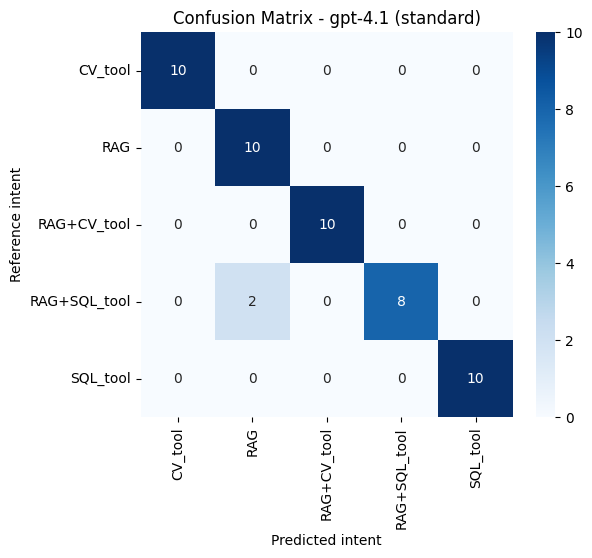

=== gpt-4o-mini (standard) (gpt-4o-mini) ===
Overall accuracy: 0.940
Classification report:
              precision    recall  f1-score   support

     CV_tool       1.00      1.00      1.00        10
         RAG       0.77      1.00      0.87        10
 RAG+CV_tool       1.00      1.00      1.00        10
RAG+SQL_tool       1.00      0.70      0.82        10
    SQL_tool       1.00      1.00      1.00        10

    accuracy                           0.94        50
   macro avg       0.95      0.94      0.94        50
weighted avg       0.95      0.94      0.94        50



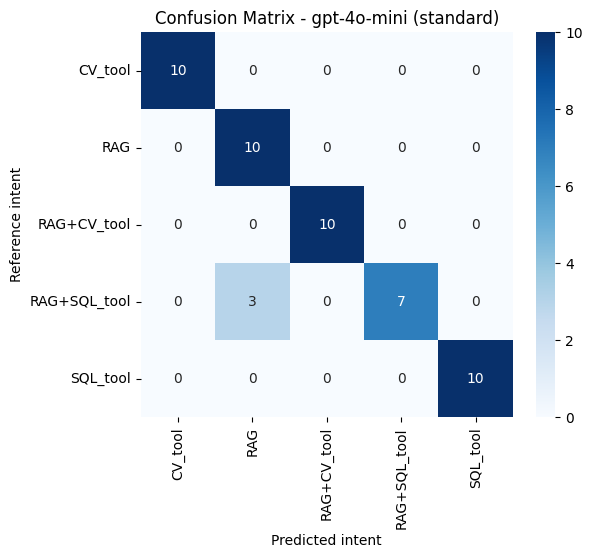

In [192]:
for model_key, artifact in ANALYSIS_ARTIFACTS.items():
    results_df = artifact["results_df"]
    if results_df.empty:
        print(f"Model {model_key} has no records; skipping.")
        continue

    cfg = artifact["config"]
    label_order = sorted({*results_df["reference_norm"], *results_df["predicted"]})
    accuracy = accuracy_score(results_df["reference_norm"], results_df["predicted"])
    print(f"=== {cfg['display_name']} ({model_key}) ===")
    print(f"Overall accuracy: {accuracy:.3f}")
    print("Classification report:")
    print(classification_report(results_df["reference_norm"], results_df["predicted"], labels=label_order, zero_division=0))

    cm = pd.crosstab(results_df["reference_norm"], results_df["predicted"], dropna=False)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted intent")
    plt.ylabel("Reference intent")
    plt.title(f"Confusion Matrix - {cfg['display_name']}")
    plt.show()





## 6. 成本估算

In [193]:
if not MODEL_RUNS:
    raise ValueError("尚未执行任何模型评估，无法生成成本汇总。")
summary_rows = []
for model_key in ANALYSIS_MODELS:
    if model_key not in MODEL_RUNS:
        continue
    artifact = MODEL_RUNS[model_key]
    cfg = artifact["config"]
    df_model = artifact["results_df"]
    prompt_tokens = artifact["prompt_tokens"]
    completion_tokens = artifact["completion_tokens"]
    price_in = cfg["price_prompt_per_1k"]
    price_out = cfg["price_completion_per_1k"]
    cost_prompt = (prompt_tokens / 1000) * price_in
    cost_completion = (completion_tokens / 1000) * price_out
    total_cost = cost_prompt + cost_completion
    avg_cost = total_cost / len(df_model)
    accuracy = accuracy_score(df_model["reference_norm"], df_model["predicted"])
    summary_rows.append({
        "model_key": model_key,
        "model_name": cfg["display_name"],
        "prompt_tokens": prompt_tokens,
        "completion_tokens": completion_tokens,
        "prompt_cost_usd": cost_prompt,
        "completion_cost_usd": cost_completion,
        "total_cost_usd": total_cost,
        "avg_cost_per_query_usd": avg_cost,
        "accuracy": accuracy,
    })
summary_df = pd.DataFrame(summary_rows)
if summary_df.empty:
    raise ValueError("ANALYSIS_MODELS 中的模型尚未运行，无法生成汇总。")
summary_df = summary_df.sort_values("total_cost_usd")
display(summary_df)


,model_key,model_name,prompt_tokens,completion_tokens,prompt_cost_usd,completion_cost_usd,total_cost_usd,avg_cost_per_query_usd,accuracy
1,gpt-4o-mini,gpt-4o-mini (standard),8748,201,0.003499,0.000322,0.003821,0.000076,0.94
0,gpt-4.1,gpt-4.1 (standard),8748,204,0.017496,0.001632,0.019128,0.000383,0.96


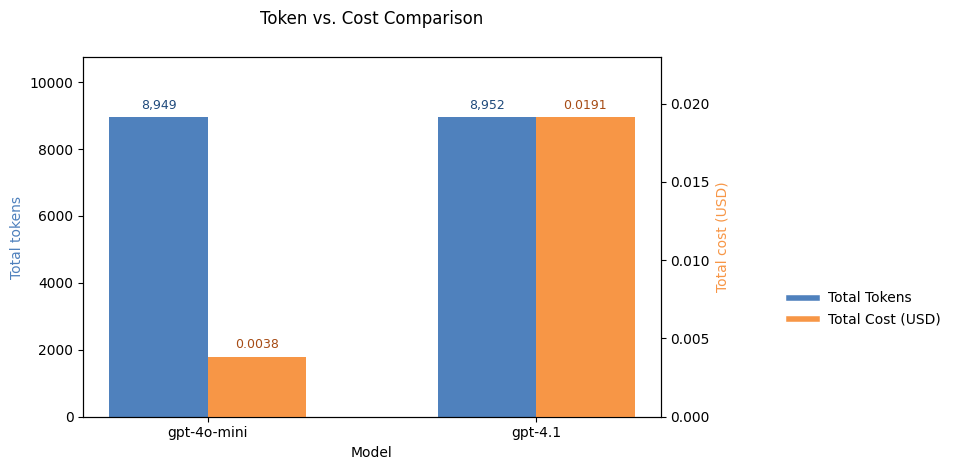

In [194]:
# Ensure summary_df exists with required columns
if 'summary_df' not in globals() or summary_df.empty or 'total_tokens' not in summary_df.columns:
    if not MODEL_RUNS:
        raise ValueError("No model runs available for plotting.")
    rebuilt_rows = []
    for model_key in ANALYSIS_MODELS:
        if model_key not in MODEL_RUNS:
            continue
        artifact = MODEL_RUNS[model_key]
        cfg = artifact["config"]
        prompt_tokens = artifact["prompt_tokens"]
        completion_tokens = artifact["completion_tokens"]
        price_in = cfg["price_prompt_per_1k"]
        price_out = cfg["price_completion_per_1k"]
        cost_prompt = (prompt_tokens / 1000) * price_in
        cost_completion = (completion_tokens / 1000) * price_out
        rebuilt_rows.append({
            "model_key": model_key,
            "model_name": cfg["display_name"],
            "total_tokens": prompt_tokens + completion_tokens,
            "total_cost_usd": cost_prompt + cost_completion,
        })
    summary_df = pd.DataFrame(rebuilt_rows)

plot_df = summary_df.sort_values("total_cost_usd")
fig, ax1 = plt.subplots(figsize=(9, 4.8))
ax2 = ax1.twinx()
width = 0.3
x = range(len(plot_df))

bars_tokens = ax1.bar([i - width / 2 for i in x], plot_df["total_tokens"], width=width, color="#4F81BD", label="Total Tokens")
bars_cost = ax2.bar([i + width / 2 for i in x], plot_df["total_cost_usd"], width=width, color="#F79646", label="Total Cost (USD)")

ax1.set_xlabel("Model")
ax1.set_ylabel("Total tokens", color="#4F81BD")
ax2.set_ylabel("Total cost (USD)", color="#F79646")
ax1.set_xticks(list(x))
ax1.set_xticklabels(plot_df["model_key"], rotation=0)
ax1.set_title("Token vs. Cost Comparison", pad=24)

ax1.set_ylim(0, plot_df["total_tokens"].max() * 1.2)
ax2.set_ylim(0, plot_df["total_cost_usd"].max() * 1.2)

for bar in bars_tokens:
    height = bar.get_height()
    ax1.annotate(f"{height:,.0f}",
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 4), textcoords="offset points",
                 ha='center', va='bottom', fontsize=9, color="#1f4a7c")

for bar in bars_cost:
    height = bar.get_height()
    ax2.annotate(f"{height:.4f}",
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 4), textcoords="offset points",
                 ha='center', va='bottom', fontsize=9, color="#a64b14")

handles = [
    plt.Line2D([0], [0], color="#4F81BD", lw=4),
    plt.Line2D([0], [0], color="#F79646", lw=4),
]
labels = ["Total Tokens", "Total Cost (USD)"]
ax1.legend(handles, labels, loc="center left", bbox_to_anchor=(1.2, 0.3), frameon=False)
plt.tight_layout(rect=[0, 0, 1.1, 1])
plt.show()



## 7. 误分类样本与备注
通过筛选 `is_correct == False` 的数据，可快速定位模型仍需改进的案例。


In [70]:
for model_key, artifact in ANALYSIS_ARTIFACTS.items():
    df_model = artifact["results_df"]
    error_cases = df_model[~df_model["is_correct"]]
    cfg = artifact["config"]
    print(f"=== 误分类样本 {cfg['display_name']} ({model_key}) === 共 {len(error_cases)} 条")
    display(error_cases[["text", "reference", "predicted", "model_output", "source"]].head(10))



=== 误分类样本 gpt-4.1 (standard) (gpt-4.1) === 共 2 条


,text,reference,predicted,model_output,source
25,Provide reasoning for decreased mowing hours u...,RAG+SQL_tool,RAG,RAG,cache
27,Discuss correlation between mowing labor cost ...,RAG+SQL_tool,RAG,RAG,cache


=== 误分类样本 gpt-4o-mini (standard) (gpt-4o-mini) === 共 3 条


,text,reference,predicted,model_output,source
25,Provide reasoning for decreased mowing hours u...,RAG+SQL_tool,RAG,RAG,cache
27,Discuss correlation between mowing labor cost ...,RAG+SQL_tool,RAG,RAG,cache
28,Explain cost efficiency differences among park...,RAG+SQL_tool,RAG,RAG,cache


## 下一步建议
- 针对误分类样本，分析模型是否缺少上下文、提示词是否需补充更细的决策规则。
- 若要比较不同模型，可在 `SELECTED_MODELS` 中增删模型 key 并重新运行批量推理；提示词也可以按需调整 `SYSTEM_PROMPT`。
- 将 `experiment/results/` 中的 CSV 与缓存纳入版本管理或归档，便于团队复现本次实验。
